## Wieso LangChain, LCEL und LangGraph

Wieso gibt es diese Abstraktionen LCEL und LangGraph.

Das hat vornehmlich historische Gründe.

- LangChain ganz zu Anfang war der Versuch, einheitliche Interfaces für LLMs, VectorStores etc. bereit zu stellen und daraus vorgefertigte Chains zu bauen.
- Damals gab es noch keine LCEL - Diese lustige Operatorschreibweise mit den Pipes |
- Dann kam die LCEL, weil man etwas Hübscheres wollte. Aus Chains wurden Runnables und ein paar andere Sachen haben sich geändert.
- Die LCEL hatte nicht vorgesehen, zyklische Datenflüsse abzubilden. Aber die Anforderungen gingen immer mehr in Richtung Agent.
- Daher die Idee, speziell für agentische, zyklische Anwendungen neue Abstraktionen zu bauen -> LangGraph.

Nun koexistieren die LCEL und LangGraph. Man möchte meist beides in größeren Anwendungen benutzen. Für simple Chains die LCEL, für komplexe Graphen LangGraph.

Die beiden Baukästen haben auch viele gemeinsame Schnittpunkte:

- Das Callback-System
- Das Config-Objekt
- Ein Graph ist auch ein Runnable
- Langsmith-Tracing
- ...

Legacy-Chains im LangChain-Repo, die nicht mit LCEL oder LangGraph erstellt wurden, werden je nach Fleiß der Commnity schrittweise umgebaut. Die alten Chains werden dann nicht mehr gepflegt.

Mit den schnell besser werdenden LLMs ändern sich die Möglichkeiten und die Anforderungen an Frameworks.

Vielleicht sieht LangChain in zwei Jahren schon wieder ganz anders aus oder ist überhaupt nicht mehr das Framework der Wahl.

Multimodale Inputs und Outputs werden die LLM-Welt auch noch einmal eine Runde weiter drehen und vielleicht neue Frameworks auf den Markt werfen.

Damit muss man leben können. Aktuell findet LangChain allerdings sehr großen Anklang. Machen wir uns also die Mühe und schauen etwas unter die Motorhaube.

### Die LCEL kennen wir schon:


In [1]:
from helpers import llm
from langchain.schema import StrOutputParser
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    "hallo Freund! Erzähle mir einen Witz über {topic}"
)
model = llm()

lcel_chain = prompt | model | StrOutputParser()

answer_str = lcel_chain.invoke({"topic": "star trek"})
print(answer_str)

Hallo! Hier ist ein Witz über Star Trek für dich:

Warum gehen die Klingonen nie ins Casino?

Weil sie Angst haben, dass sie ihre „Schiffe“ verlieren! 🚀😄

Ich hoffe, der hat dir gefallen!


### Nun wollen wir uns LangGraph anschauen und uns einen Agenten selbst bauen ohne Import von Prebuilt

Das Erstellen von eigenen Graphen ist die eigentliche Super-Power von LangGraph.

Unser einfachster Graph hat nicht einmal ein Tool. Er hat nur eine Node, das LLM. Das tut natürlich nicht viel, aber wir fangen simpel an.


In [2]:
from langgraph.graph import MessageGraph

# MessageGraph ist eine kleine Abstraktion. Das ist nichts anderes als StateGraph(List[MessageLikeObject])
graph_builder = MessageGraph()
# Wir definieren unser LLM als einzigen Knoten
graph_builder.add_node("chatbot_node", model)
# Dieser Knoten wird der Entrypoint
graph_builder.set_entry_point("chatbot_node")
# Von diesem Knoten geht es direkt zu "END", dem vordefinierten Terminalknoten
graph_builder.set_finish_point("chatbot_node")

# Jetzt kompilieren wir
simple_graph = graph_builder.compile()

#### Den Graph darstellen


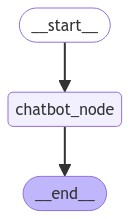

In [3]:
from IPython.display import Image

display(Image(simple_graph.get_graph().draw_mermaid_png()))

In [4]:
from langchain_core.messages import HumanMessage

inputs = HumanMessage(content="Hello, my name is Bob")


message_history = simple_graph.invoke(inputs)
for message in message_history:
    message.pretty_print()

================================ Human Message =================================

Hello, my name is Bob
================================== Ai Message ==================================

Hello, Bob! How can I assist you today?


#### Nun bauen wir zur Übung den Agenten aus dem bekannten Diagramm selbst.

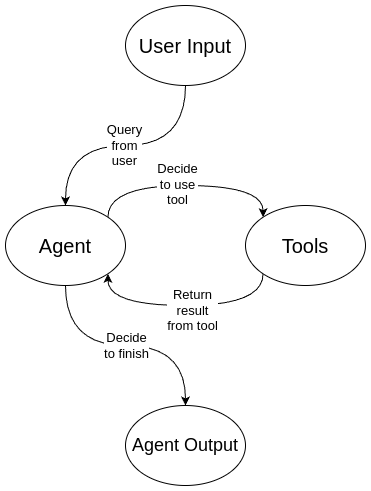


#### Wir definieren ein Tool


In [5]:
from langchain.tools.arxiv.tool import ArxivQueryRun

tool = ArxivQueryRun()

#### Wir definieren zur Übung manuell unseren AgentState


In [6]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

#### Wir binden unser tool ans LLM. Das ist Magie, die OpenAI-Modelle mit sich bringen.

Hä? Tools ans LLM binden?

- Wir hatten oben gesehen, dass unser LLM genau wissen muss, welche Tools es benutzen darf.
- Bei OpenAI und andere großen LLM Providern kann man einfach die Tools an das LLM binden. Damit werden die erlaubten Tools automatisch von OpenAI ans Prompt gehängt.
- Was bringt das? Die Toolbeschreibungen landen in dem von OpenAI gewünschten Format im Prompt. Das macht Toolcalling zuverlässiger. Außerdem erspart es Arbeit.


In [7]:
model_with_tools = model.bind_tools([tool])

#### Wir betten das Tool und das LLM nun in Funktionen ein, die die folgende Signatur haben

- Input: Der State
- Output: Modifikation des State

Diese Funktionen werden die Knoten.


In [8]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import chain
from langgraph.prebuilt import ToolNode

tools = [tool]


@chain
def tool_executor(tool_call):
    tool = {tool.name: tool for tool in tools}[tool_call["name"]]
    return ToolMessage(tool.invoke(tool_call["args"]), tool_call_id=tool_call["id"])


def agent(state):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


tool_node = ToolNode(tools)

#### Die Kanten bekommen als Input den State, aber modifizieren ihn nicht


In [9]:
from typing import Literal

from langgraph.graph import END


def should_continue(state) -> Literal["call_tools", END]:  # type: ignore
    return "call_tools" if state["messages"][-1].tool_calls else END

#### Kompilieren. Kennt man schon


In [10]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.add_node("call_tools", tool_node)

graph_builder.set_entry_point("agent")

graph_builder.add_conditional_edges("agent", should_continue)

graph_builder.add_edge("call_tools", "agent")

graph_with_tools = graph_builder.compile()

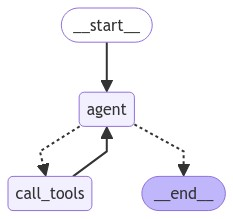

In [11]:
display(Image(graph_with_tools.get_graph().draw_mermaid_png()))

In [12]:
inputs = {
    "messages": [
        HumanMessage(content="Write a very short summary about supernovas. Use Arxiv.")
    ]
}

In [13]:
for chunk in graph_with_tools.stream(inputs):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  arxiv (call_G5x3nq1XJhbZrEdkgqeY2McX)
 Call ID: call_G5x3nq1XJhbZrEdkgqeY2McX
  Args:
    query: supernova
================================= Tool Message =================================
Name: arxiv

Published: 2015-05-06
Title: SOUSA's Swift Supernova Siblings
Authors: Peter J. Brown
Summary: Swift has observed over three hundred supernovae in its first ten years.
Photometry from the Ultra-Violet Optical Telescope (UVOT) is being compiled in
the Swift Optical/Ultraviolet Supernovae Archive (SOUSA). The diversity of
supernovae leads to a wide dynamic range of intrinsic properties. The intrinsic
UV brightness of supernovae as a function of type and epoch allows one to
understand the distance ranges at which Swift can reliably detect supernovae.
The large Swift sample also includes supernovae from the same galaxy as other
Swift supernovae. Through the first ten years, these families include 34

## ✅ Aufgabe

Der Surfer im Netz hat sicherlich nicht genug Zeit, unseren gesamten tollen Artikel über Supernovas zu lesen. Wir wollen deshalb ganz sicher sein, dass die Zusammenfassung nicht mehr als 120 Zeichen beinhaltet.

Wir können in unserer conditional_edge einfach prüfen, wie lange der String ist. Wenn er zu lange ist, fragen wir das LLM (in einer Node, die wir neu definieren), ob es das bitte kürzer fassen kann.


In [ ]:
def should_continue(state) -> Literal["call_tools", "rewrite", END]:  # type: ignore
    if state["messages"][-1].tool_calls:
        return "call_tools"
    elif len(state["messages"][-1].content) <= 120:
        return END
    # Hier die Conditional Edge vervollständigen

In [ ]:
from langchain.schema import SystemMessage


def rewrite(state):
    too_long_summary = state["messages"][-1].content
    rewriter_input = [
        SystemMessage(
            content="Please shorten this text. It must be less than 120 characters."
        ),
        HumanMessage(content=too_long_summary),
    ]
    # Den Output des Rewriters zurückgeben
    return {"messages": [response]}

In [ ]:
# Den Graph vervollständigen. Eine zusätzliche Node und eine zusätzliche Conditional Edge sind ausreichend.
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.add_node("call_tools", call_tools)
# graph_builder.add_node...

graph_builder.set_entry_point("agent")
graph_builder.add_conditional_edges("agent", should_continue)
# graph_builder.add_conditional_edges...
graph_builder.add_edge("call_tools", "agent")

graph_with_many_loops = graph_builder.compile()

In [ ]:
display(Image(graph_with_many_loops.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in graph_with_many_loops.stream(inputs):
    for state in chunk.values():
        for message in state["messages"]:
            message.pretty_print()